## Notebook for testing data for pilot 3

Pilot 3 added more checks for engagement early in the experiment.
Iteration names:
'pre-pilot3':

In [95]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

In [96]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [113]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['compositional-abstractions']
coll = db['two-towers']

# which iteration name should we use?
iterationName = 'pilot3'

## look up number of trials (including paired-practice)
numTrials = 13

### construct tidy dataframe with game data

### establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

`ssh -fNL 27017:127.0.0.1:27017 USERNAME@cogtoolslab.org`

#### Pass in list of iterations, returns list of total games and completed games for each

In [114]:
## get list of all gameIDs in database
#iterationList = ['livetest0','pilot0','pilot2']

iterationList = ['pilot3']

for iteration in iterationList:
    #get total games
    total_games = coll.find({'iterationName':iteration}).distinct('gameid')
    print('There are {} total games in iteration: {}.'.format(len(total_games), iteration))

    ## get list of complete gameIDs
    gameIDs = coll.find({'iterationName':iteration}).distinct('gameid')
    complete_games = [g for g in gameIDs if len(coll.find({'gameid':g}).distinct('trialNum')) == numTrials]
    print('There are {} complete games in iteration: {}.'.format(len(complete_games), iteration))

There are 0 total games in iteration: pilot3.
There are 0 complete games in iteration: pilot3.


In [60]:
broken_games = []
complete_games = [g for g in complete_games if g not in broken_games]

def construct_tidy_dataframe(eventType = 'chatMessage', 
                             complete_games = [],
                             iterationName = 'pilot1',
                             remove_workerID = True):
    '''
    input: list of complete games and name of event Type
    '''
    event2name = {'chatMessage':'chat', 'block':'block', 'endTrial':'trial', 'exitSurvey':'exit'}
    L = pd.DataFrame()
    for g, this_gameID in enumerate(complete_games):
        print('Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games)))
        clear_output(wait=True) 

        ### extract records 
        #loop over iteration names??
        X = coll.find({ '$and': [{'iterationName':iterationName}, 
#                                  {"$or":[{'iterationName':'Exp2Pilot3'},
#                                  {'iterationName':'Exp2Pilot3_batch2'}]}
                                 {'gameid': this_gameID}, {'eventType': eventType}]}).sort('time') 
        
        li = list(X)        
        _L = pd.DataFrame(li)  

        ## concat with previous game's dataframe
        if L.shape[0]==0:
            L = _L
        else: 
            L = pd.concat([L,_L], axis=0)     

    ## postprocessing
    if remove_workerID and 'workerId' in L.columns:
        L = L.drop('workerId',axis=1)

    ## save out group dataframe to csv dir
    out_path = os.path.join(csv_dir,'compabs_{}_{}.csv'.format(event2name[eventType],iterationName))
    print('Saving dataframe out to CSV dir at path: {}'.format(out_path))    
    L.to_csv(out_path)             

    return L


In [61]:
## construct dataframe for each datatype
dataTypes = coll.distinct('eventType')
for thisDataType in dataTypes:
    X = construct_tidy_dataframe(eventType=thisDataType, complete_games=complete_games, iterationName=iterationName)


Saving dataframe out to CSV dir at path: /Users/will/compositional-abstractions/results/csv/compabs_exit_pre-pilot3.csv


## Full DF from DB

In [117]:
query = coll.find({'iterationName':'pilot3'})

df_full = pd.DataFrame(list(query))
df_full

""


In [99]:
## How many records?
coll.estimated_document_count()

6419

In [111]:
df_full[df_full.iterationName=='pilot3']

,_id,iterationName,gameid,time,workerId,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,confused,comments,strategy,role,totalLength,cumulativeScore,cumulativeBonus,trialScore,workerID,individualPracticeAttempts


#### check outcome for specific workerID
Must pass in workerID and corresponding iteration

In [67]:
#set worker ID
workerID = 'testsubject003'

#get GameID (not all info available at workerID level (e.g. bonus))
gameID = df_full[df_full['workerId'] == workerID]['gameid'].unique()[0]

#check iteration name
df_game = df_full[(df_full['iterationName'] == iterationName) &
                            (df_full['gameid'] == gameID)]
#get workerIds
print('workerIDS:',df_game['workerId'].unique())
#get bonus for gameID ([air of workerIDs])
print("Bonus:",np.nanmax(df_game['cumulativeBonus']))

workerIDS: ['testsubject003' 'testsubject002']
Bonus: 0.0


In [68]:
#see full history for single worker
df_test = df_full[(df_full['iterationName'] == iterationName)&
                           (df_full['workerId'] == workerID)]
df_test.content.unique()

array(['sergaerg', nan, 'aerr'], dtype=object)

In [77]:
df_full['workerId'].unique()

array(['A1MMCS8S8CTWKU', '', 'A4SSYO0HDVD4E', 'undefined',
       'A22ZZCICZDCSTY', 'A52FUUEDGSZT9', 'A3D2U4QF7821ZW',
       'A2S64AUN7JI7ZS', 'A1VR1XQEQQXYUE', 'A2XK59FYAFO9EX',
       'A1U43WUOJQBK5T', 'A1ZF2GZ2ZRV8OY', 'AD66HP7KFSKJG',
       'A1BOIDKD33QSDK', 'A15J42M6EC7Y1K', 'A8028AFBBS29G',
       'A272X64FOZFYLB', 'A3QDEUEUOX24NB', 'A3OVBNOFPMCDAS',
       'A2ZAOMB6O3ACAV', 'ALYR5CI2SM2JC', 'AH00EJ6PK1H3A',
       'A3DUL880Y08G95', 'A2Y7RA3JIQXV6M', 'A2GV9WSNSPX53',
       'A2J18K5IUQ2K4G', 'A3TBR9GIXU42DM', 'A12XVSIL669PVI',
       'A2QNVAMUHLUVMU', 'A25D8MUZP7CQEY', 'A1ATL3G98SFW4V',
       'A3ERKH1ZX3VH0Z', 'A8KX1HFH8NE2Q', 'A2TFKXM3RYT39Y',
       'A1CY7IOJ9YH136', 'ACWVHNV57A8IJ', 'A1O8D22H0D03W1',
       'AP9WIQ4P78XLH', 'A2WDF40FA670T9', 'A38FIMIHKIJYDN',
       'A1UEX245I12ZH7', 'A37XBH865833FE', 'AT6LDQNLKTUSE',
       'A1V2H0UF94ATWY', 'AU75DIKTVX5GP', 'ABNH026RZU28C',
       'A4LFXI796SAOA', 'AO6YL3KHP84EX', 'A258ZJM0HU1OR3',
       'AVBRJBJONL47I', 'A12FTSX85NQ8N9'

In [79]:
df_cw = df_full[(df_full['iterationName'] == iterationName)][df_full['workerId'].isin(['camerontesting1','will000testing1'])]

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [83]:
df_cw.eventType.unique()

array(['chatMessage', 'block', 'endTrial', 'exitSurvey'], dtype=object)

In [94]:
df_cw[df_cw.eventType=='block']

,_id,iterationName,gameid,time,workerId,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,confused,comments,strategy,role,totalLength,cumulativeScore,cumulativeBonus,trialScore,workerID,individualPracticeAttempts
6115,5f4406b1c5668f67e677fba7,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,horizontal,vertical,practice,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6116,5f4406b4c5668f67e677fba8,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,horizontal,vertical,practice,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6119,5f4406c2c5668f67e677fbab,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,C,Pi,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6120,5f4406c3c5668f67e677fbac,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,C,Pi,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6121,5f4406c4c5668f67e677fbad,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,C,Pi,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6236,5f440811c5668f67e677fc20,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,Pi,L,11,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6237,5f440812c5668f67e677fc21,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,Pi,L,11,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6238,5f440813c5668f67e677fc22,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,Pi,L,11,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6239,5f440815c5668f67e677fc23,pre-pilot3,0249-5e989b45-8e74-4f49-ba9a-aa0b971f485c,1.598294e+12,will000testing1,undefined,Pi,L,11,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## Trial Level Data

## Create DF for each event


In [13]:
#read in dataframes from each eventType
df_block = pd.read_csv('../results/csv/compabs_block_{}.csv'.format(iterationName))
df_chat = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format(iterationName))
df_exit = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format(iterationName))
df_trial = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format(iterationName))

In [84]:
#manually build full df (needs to be generalized)
#
df_block0 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('livetest0'))
df_chat0 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('livetest0'))
df_exit0 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('livetest0'))
df_trial0 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('livetest0'))
#
df_block1 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('pilot0'))
df_chat1 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('pilot0'))
df_exit1 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('pilot0'))
df_trial1 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('pilot0'))
#
df_block2 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('pilot2'))
df_chat2 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('pilot2'))
df_exit2 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('pilot2'))
df_trial2 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('pilot2'))

df_block = pd.concat([df_block0,df_block1,df_block2])
df_chat = pd.concat([df_chat0,df_chat1,df_chat2])
df_exit = pd.concat([df_exit0,df_exit1,df_exit2])
df_trial = pd.concat([df_trial0,df_trial1,df_trial2])

print("Total Completed Games:",len(df_exit.gameid.unique()))

Total Completed Games: 21


#### Write to data frames

In [91]:
df_block.to_csv('df_block.csv', header=True, index=False) 
df_chat.to_csv('df_chat.csv', header=True, index=False) 
df_exit.to_csv('df_exit.csv', header=True, index=False) 
df_trial.to_csv('df_trial.csv', header=True, index=False) 

#### Exclusion Criteria

In [92]:
#How many dyads fulfill 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']
print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75[df75['trials']>=9]))

Total dyads achieving 75% Accuracy on 75% of trials: 13


In [89]:
#df_exit2 = pd.read_csv('../results/csv/compabs_exit_pilot2.csv')
df_exit.confused

AttributeError: 'DataFrame' object has no attribute 'confused'

#### Total Game Duration (for Gameplay)

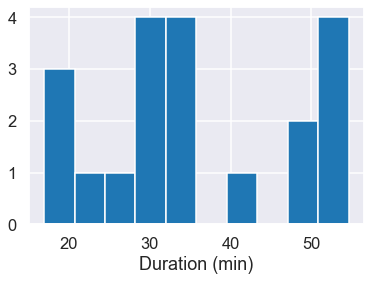

In [19]:
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).hist()
plt.xlabel("Duration (min)")
plt.show()

In [20]:
#average completion time
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).mean()

35.44269333333333

### Inspect some raw data: language

In [21]:
#create columns for char and word counts
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()
df_chat['char_count'] = df_chat['content'].str.len()

In [22]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_chat['trialNum'] = pd.to_numeric(df_chat['trialNum'], errors = 'coerce')

In [23]:
#inspect specific chat history of one dyad
dyadGameId = '8548-343a533f-0369-4b20-bbd4-a00f25359cea'
df_chat[(df_chat.gameid == dyadGameId)]['content'].unique()

array(['move left', 'move right\n', 'build the block\n',
       'build the red block\n', 'move the right block to the left',
       'move the lift block to the right\n', 'move the right red',
       'build the blue block', 'bulid the red block',
       'move the right bulid the left', 'move the blue block',
       'move the left block to the right corner',
       'build the block to next blue block',
       'move the red block to the right corner to the blue block',
       'move to left block to right', 'move the next block', 'move right',
       'bulid the right the left block\n', 'move left\n',
       'bulid the right to left block', 'move left to right block',
       'move right to left block ', 'mobe left', 'movbe left'],
      dtype=object)

### Inspect some raw data: display block towers

In [24]:
importlib.reload(drawing)
df_block['w'] = df_block['width']
df_block['h'] = df_block['height']
floatCols = ['w','h','blockNum','turnNum','x','y']
df_block[floatCols] = df_block[floatCols].applymap(np.int64)

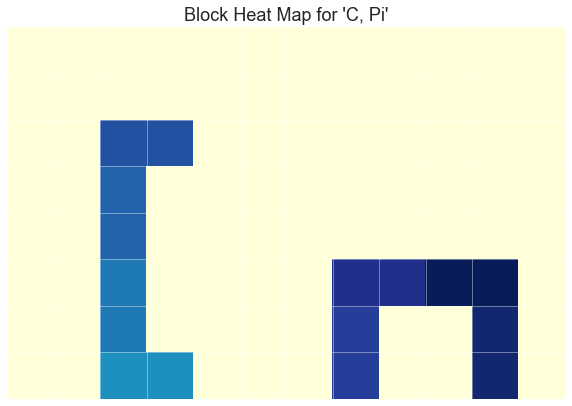

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
drawing.draw_from_actions_subplot(df_block[(df_block.leftTarget == 'C') & 
                                           (df_block.rightTarget == 'Pi') &
                                           (df_block.gameid == '0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2')], 
                                  ax, 
                                  world_size = [12,8])
plt.title("Block Heat Map for 'C, Pi'")
plt.show()

## Make basic visualizations and calculate descriptives

### Architect: mean number of words across trials

In [26]:
#Get sum of words for each trial, group by game then average across games
print(df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean())

trialNum
0.0     55.35
1.0     49.50
2.0     38.95
3.0     33.90
4.0     33.00
5.0     28.20
6.0     23.25
7.0     21.60
8.0     19.15
9.0     17.95
10.0    17.90
11.0    17.95
Name: word_count, dtype: float64


Text(0, 0.5, 'Word Count')

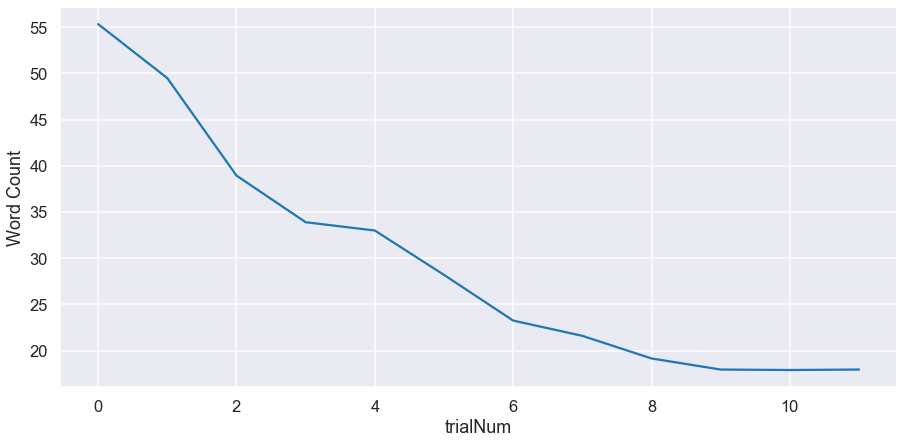

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Word Count')

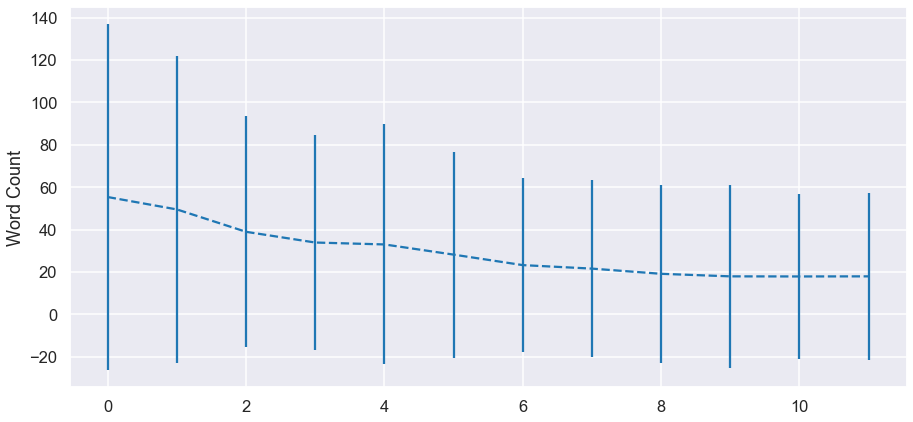

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
mean = df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean()
std = df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).std()

plt.errorbar(mean.index, mean, yerr=2*std, linestyle='--')
plt.ylabel('Word Count')
plt.show()

Text(0, 0.5, 'Word Count')

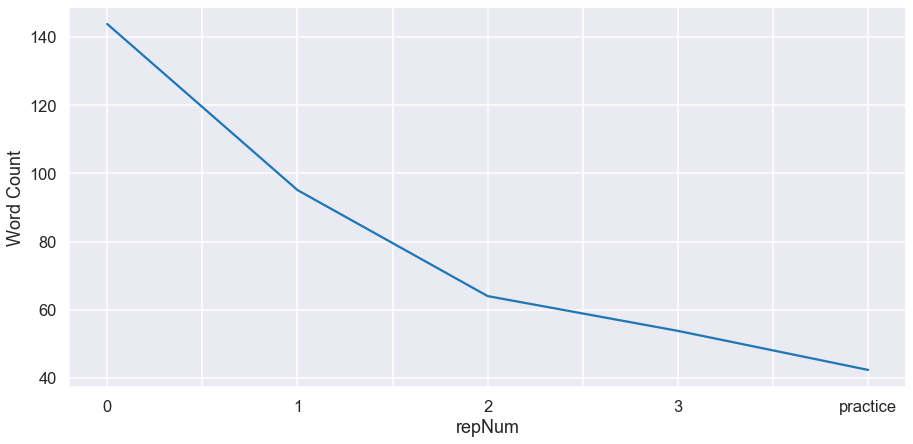

In [51]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','repNum'])['word_count'].sum().groupby(['repNum']).mean().plot(ax = ax)
plt.ylabel('Word Count')

###  Architect: mean number of characters across trials

Text(0, 0.5, 'Char Count')

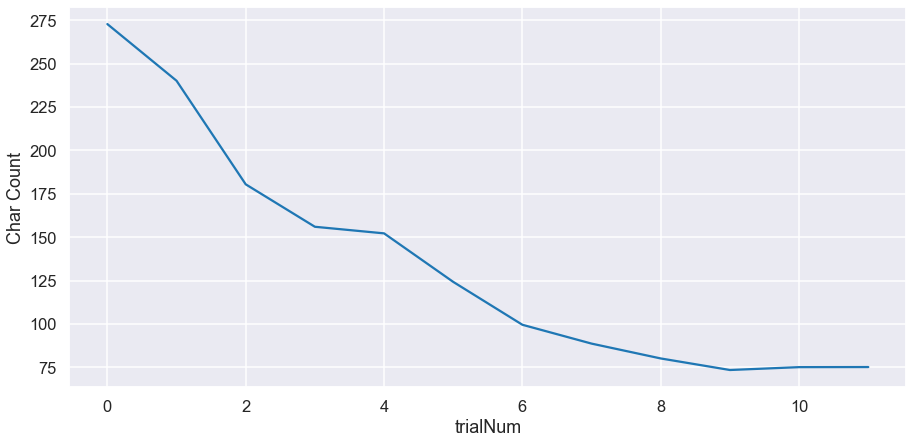

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['char_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Char Count')

### Architect: mean number of messages (across turns within a trial) across trials

Text(0, 0.5, 'Messages per trial')

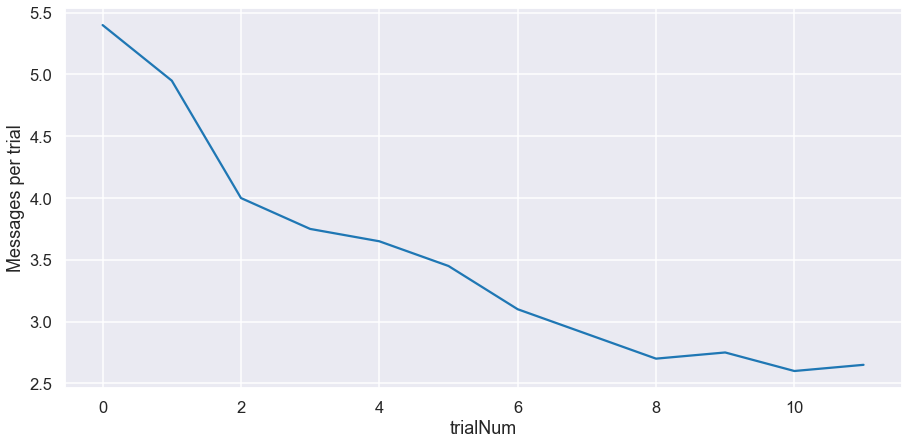

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['_id'].count().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Messages per trial')

### Architect: Total typing time (across turns within at trial) across trials

In [31]:
#check time elapsed
df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

Text(0, 0.5, 'Average Time elapsed, Architect')

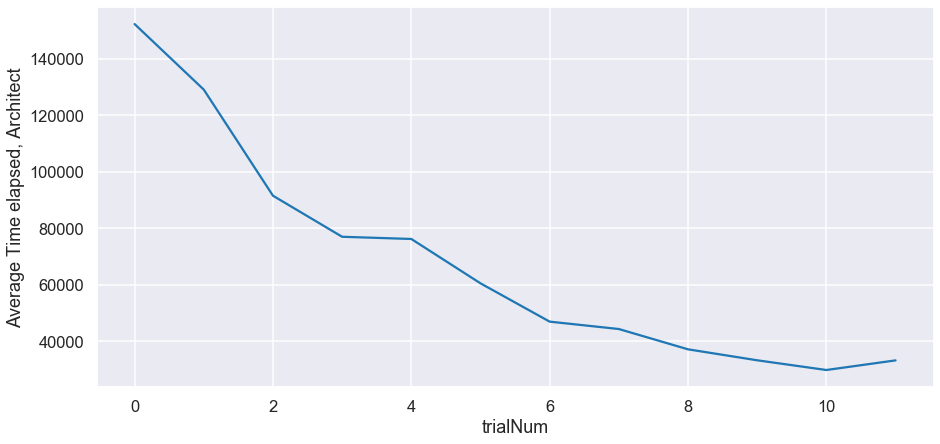

In [32]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Architect')

In [33]:
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean()

trialNum
0.0     152317.30
1.0     129113.90
2.0      91571.75
3.0      77040.30
4.0      76259.70
5.0      60563.00
6.0      47003.85
7.0      44389.60
8.0      37205.60
9.0      33323.25
10.0     29886.65
11.0     33289.20
Name: timeElapsedInTurn, dtype: float64

### Builder: Reconstruction accuracy (intersection over union, IOU) across trials

In [34]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_trial['trialNum'] = pd.to_numeric(df_trial['trialNum'], errors = 'coerce')
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_block['trialNum'] = pd.to_numeric(df_block['trialNum'], errors = 'coerce')

Text(0, 0.5, 'Trial Score')

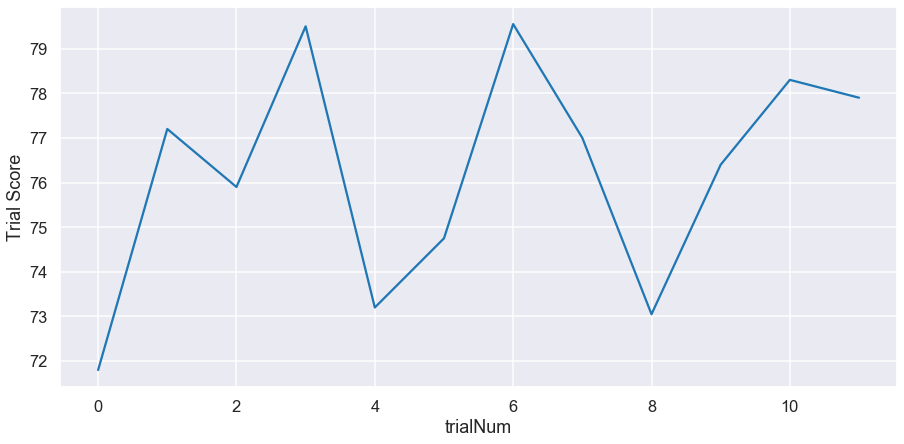

In [35]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

Text(0, 0.5, 'Trial Score')

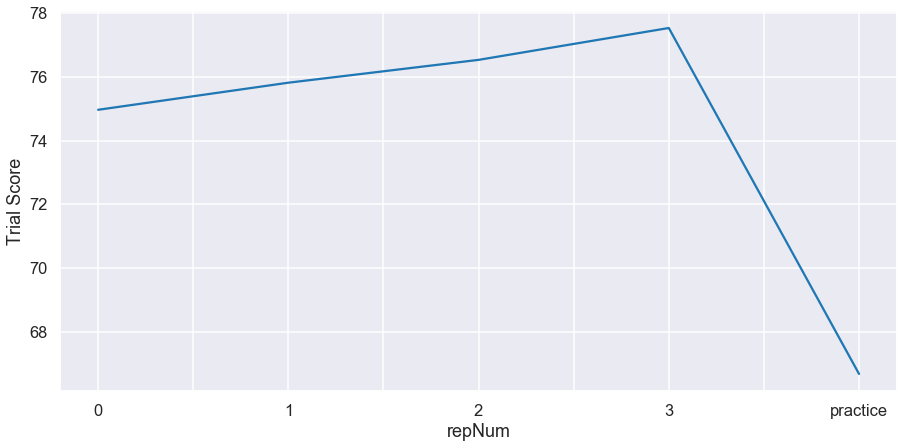

In [55]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['gameid','repNum'])['trialScore'].mean().groupby(['repNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

Text(0, 0.5, 'Trial Score')

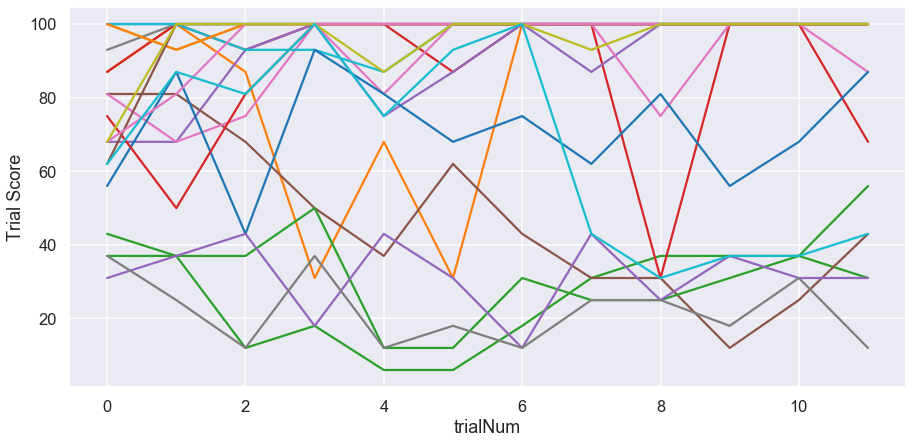

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

Text(0, 0.5, 'Trial Score')

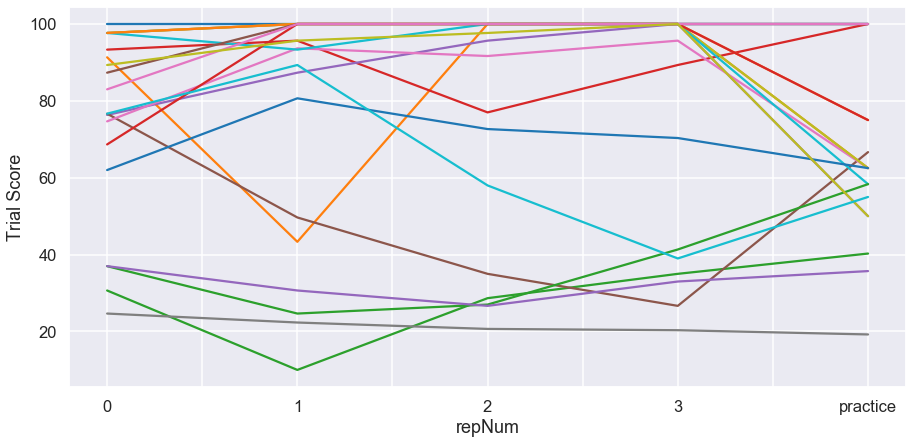

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['repNum','gameid'])['trialScore'].mean().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

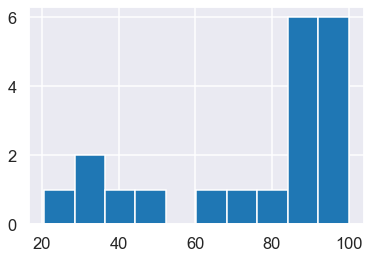

In [38]:
df_trial.groupby(['gameid'])['trialScore'].mean().hist()

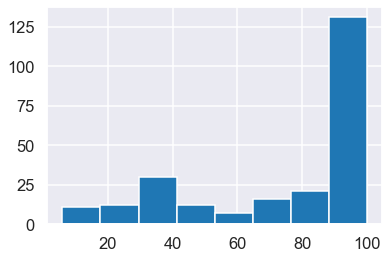

In [39]:
#Dist of trial scores:
(df_trial.groupby(['gameid','trialNum']).trialScore.max().hist(bins = 8))
plt.show()


In [40]:
pd.options.display.max_rows = 4000
df_trial.groupby(['gameid','trialNum']).trialScore.max()

gameid                                     trialNum
0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2  0.0         100.0
                                           1.0         100.0
                                           2.0         100.0
                                           3.0         100.0
                                           4.0         100.0
                                           5.0         100.0
                                           6.0         100.0
                                           7.0         100.0
                                           8.0         100.0
                                           9.0         100.0
                                           10.0        100.0
                                           11.0        100.0
1494-029e2297-bd3f-4cfe-be00-d06d36724e4e  0.0          87.0
                                           1.0         100.0
                                           2.0          87.0
                                 

### Architect: Distribution of words over trials

### Builder: Distribution of blocks placed per utterance


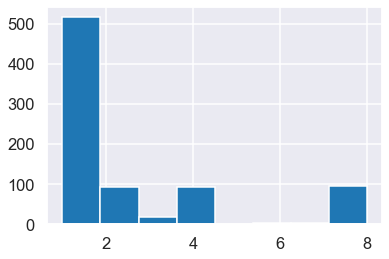

In [42]:
(df_block.groupby(['gameid','trialNum', 'turnNum'])['_id'].count()).hist(bins = 8)
plt.show()


### Builder: Total reconstruction time (summed build time across turns, within each trial) across trials

In [43]:
#check time elapsed
df_block["timeElapsedInTurn"] = pd.to_numeric(df_block['timeElapsedInTurn'])

In [44]:
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum()

gameid                                     trialNum
0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2  0.0         124294.0
                                           1.0         127660.0
                                           2.0         296930.0
                                           3.0         178785.0
                                           4.0         198308.0
                                           5.0         285694.0
                                           6.0          87753.0
                                           7.0          92469.0
                                           8.0         106286.0
                                           9.0          80902.0
                                           10.0         95916.0
                                           11.0         85878.0
1494-029e2297-bd3f-4cfe-be00-d06d36724e4e  0.0         106131.0
                                           1.0          84608.0
                                           2.0      

Text(0, 0.5, 'Average Time elapsed, Builder')

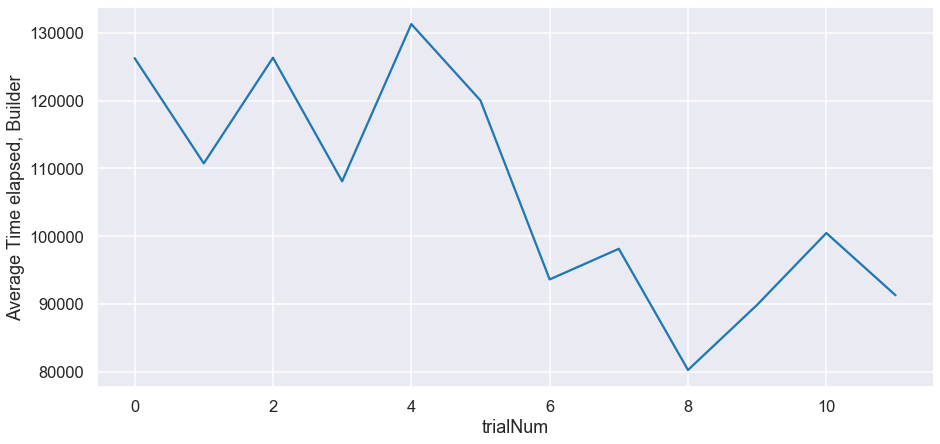

In [45]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Builder')

Text(0, 0.5, 'Time elapsed in trial Builder')

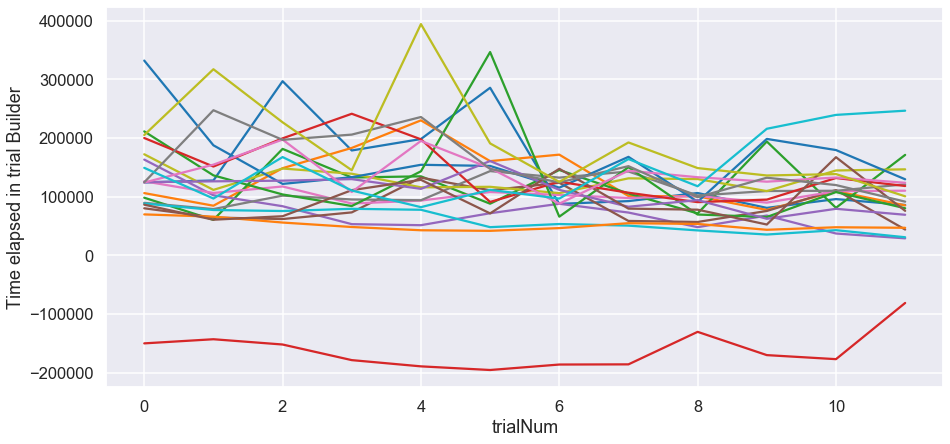

In [46]:
## line plots: time for each builder
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['trialNum','gameid'])['timeElapsedInTurn'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Time elapsed in trial Builder')

In [47]:
df_block.timeElapsedInTurn.min()

-28382.0

### Now, let's look at the DVs above, w.r.t. repetition of scenes, IGNORING which side a tower appears on... so across four repetitions (where [A,B] is equivalent to [B,A])

#### use rep num

TBD. We've done this in the R notebook though....

In [48]:
#
def convert(list): 
    return tuple(i for i in list)
df_chat['targetSet'] = convert(df_chat[['leftTarget', 'rightTarget']].values.tolist())

Text(0, 0.5, 'Words Per figure')

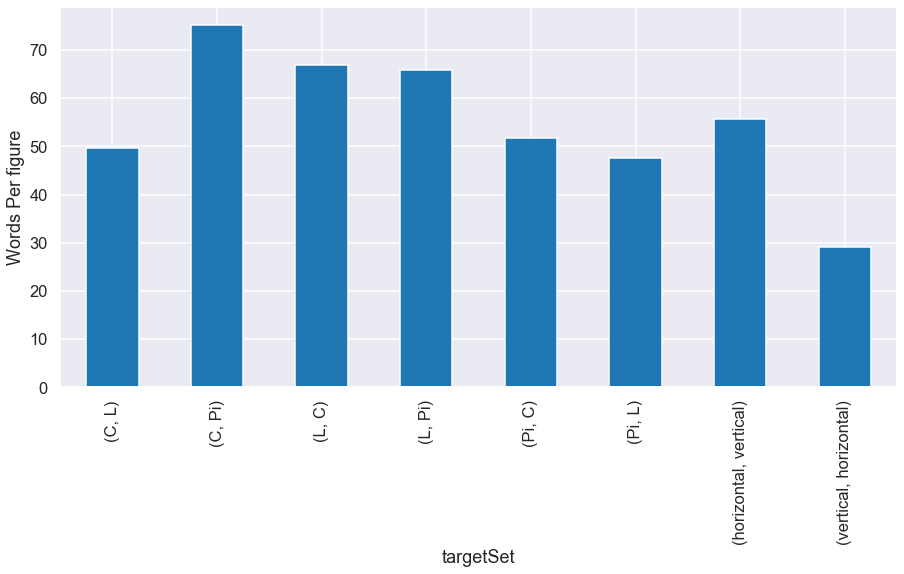

In [50]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','targetSet'])['word_count'].sum().groupby(['targetSet']).mean().plot.bar(ax = ax)
plt.ylabel('Words Per figure')